## Script is used to model different distributions of 'foreign key' discrepancies. These 'foreign key discrepancies' are defined as instances where the start and end dates of the

### NOTE: This notebook is limited in terms of utility until the following problem is addressed:

Many of the sites are uploading their date information in their local timezone (e.g. 12-11-2019). They are also uploading their datetime information in their local timezone (e.g. 12-11-2019 22:00 EST). Bigquery, however, applies a rule to their datetime information to adjust for time zone differences (e.g. the 12-11-2019 22:00 EST would turn into 12-12-2019 03:00 UTC).

The issue, however, arises when the datetime object is towards the end of the day and this conversion ‘pushes'  the date of the datetime into the following day UTC. Since the ‘date’ object is never adjusted, the ‘dates' of the date and datetime are not considered equal and thus removed by one of our cleaning rules.

In [1]:
from notebooks import bq, render, parameters

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import table 
%matplotlib inline
import six
import scipy.stats
import math
import seaborn as sns
import pandas as pd
import matplotlib

In [2]:
DATASET = parameters.LATEST_DATASET

print("""
DATASET TO USE: {}
""".format(DATASET))


DATASET TO USE: aou-res-curation-prod.ehr_ops



In [22]:
procedure_visit_df

,src_hpo_id,num_bad_records,procedure_vis_start_diff,procedure_vis_end_diff,procedure_vis_start_dt_diff,procedure_vis_end_dt_diff,procedure_dt_vis_start_dt_diff,procedure_dt_vis_end_dt_diff,all_discrepancies_equal,total_diff
0,aouw_mcri,42,0,4,0,5,0,5,False,14
1,aouw_mcri,40,0,62,1,62,1,62,False,188
2,aouw_mcri,38,0,47,1,47,1,47,False,143
3,aouw_mcri,37,0,65,0,65,0,65,False,195
4,aouw_mcri,37,0,4,0,4,0,4,False,12
5,aouw_mcri,33,0,6,0,6,0,6,False,18
6,aouw_mcri,32,0,5,0,5,0,5,False,15
7,aouw_mcri,31,0,4,0,4,0,4,False,12
8,aouw_mcri,31,0,3,0,3,0,3,False,9
9,aouw_mcri,29,0,7,0,7,0,7,False,21


### The below query is used to generate a 'procedure/visit dataframe'. This procedure shows the difference between the start/end times for the same visit_occurrence_id with respect to the procedure table.

### Each row shows information for:
- The difference between the visit start date and the procedure date
- The difference between the visit end date and the procedure date
- The difference between the visit start datetime (as a date) and the procedure date
- The difference between the visit end datetime (as a date) and the procedure date
- The difference between the visit start datetime (as a date) and the procedure datetime (as a date)
- The difference between the visit end datetime (as a date) and the procedure datetime (as a date)
- The sum of all the values listed above

In [3]:
p_v_query = """
SELECT
DISTINCT
a.*, 
(a.procedure_vis_start_diff + a.procedure_vis_end_diff + a.procedure_vis_start_dt_diff + a.procedure_vis_end_dt_diff + a.procedure_dt_vis_start_dt_diff + a.procedure_dt_vis_end_dt_diff) as total_diff
FROM 
( SELECT
  mpo.src_hpo_id, COUNT(mpo.src_hpo_id) as num_bad_records, 
  IFNULL(ABS(DATE_DIFF(po.procedure_date, vo.visit_start_date, DAY)), 0) as procedure_vis_start_diff,
  IFNULL(ABS(DATE_DIFF(po.procedure_date, vo.visit_end_date, DAY)), 0) as procedure_vis_end_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), po.procedure_date, DAY)), 0) as procedure_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), po.procedure_date, DAY)), 0) as procedure_vis_end_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(po.procedure_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)), 0) as procedure_dt_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(po.procedure_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY)), 0) as procedure_dt_vis_end_dt_diff,

  (
  ABS(DATE_DIFF(po.procedure_date, vo.visit_start_date, DAY)) = 
  ABS(DATE_DIFF(po.procedure_date, vo.visit_end_date, DAY)) 
  AND
  ABS(DATE_DIFF(po.procedure_date, vo.visit_end_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), po.procedure_date, DAY)) 
  AND
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), po.procedure_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), po.procedure_date, DAY))
  AND
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), po.procedure_date, DAY)) = 
  ABS(DATE_DIFF(CAST(po.procedure_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) 
  AND
  ABS(DATE_DIFF(CAST(po.procedure_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) = 
  ABS(DATE_DIFF(CAST(po.procedure_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY))
  ) as all_discrepancies_equal

  FROM
  `{}.unioned_ehr_procedure_occurrence` po
  LEFT JOIN
  `{}._mapping_procedure_occurrence` mpo
  ON
  po.procedure_occurrence_id = mpo.procedure_occurrence_id
  LEFT JOIN
  `{}.unioned_ehr_visit_occurrence` vo
  ON
  po.visit_occurrence_id = vo.visit_occurrence_id

  WHERE
    -- must have populated visit occurrence id
    (
    po.visit_occurrence_id IS NOT NULL
    AND
    po.visit_occurrence_id <> 0
    AND
    vo.visit_occurrence_id IS NOT NULL
    AND
    vo.visit_occurrence_id <> 0
    )

  AND
    (
    -- problem with procedure date
    (po.procedure_date < vo.visit_start_date
    OR
    po.procedure_date > vo.visit_end_date)

    OR 
    -- problem with datetime
    (po.procedure_datetime < vo.visit_start_datetime
    OR
    po.procedure_datetime > vo.visit_end_datetime )

    OR
    -- problem with the datetime (extracting date for comparison)
    (po.procedure_date < CAST(vo.visit_start_datetime AS DATE)
    OR
    po.procedure_date > CAST(vo.visit_end_datetime AS DATE))
    
    OR
    
    --problem with the datetime
    (CAST(po.procedure_datetime AS DATE) < CAST(vo.visit_start_datetime AS DATE)
    OR
    CAST(po.procedure_datetime AS DATE) > CAST(vo.visit_end_datetime AS DATE)
    )
    )

  GROUP BY mpo.src_hpo_id, po.procedure_date, vo.visit_start_date, vo.visit_end_date, vo.visit_start_datetime, vo.visit_end_datetime, po.procedure_datetime
  ORDER BY all_discrepancies_equal ASC, num_bad_records DESC
) a
WHERE
-- cannot compare date/datetime date accurately because of problem with UTC dates not converting properly. give 'wiggle room ' of 1
(
a.procedure_vis_start_dt_diff > 1
OR
a.procedure_vis_end_dt_diff > 1
OR
a.procedure_vis_start_diff > 0
OR
a.procedure_vis_end_diff > 0
OR
a.procedure_dt_vis_start_dt_diff > 0
OR
a.procedure_dt_vis_end_dt_diff > 0
)
ORDER BY src_hpo_id ASC, num_bad_records DESC, total_diff DESC, all_discrepancies_equal ASC
""".format(DATASET, DATASET, DATASET)

procedure_visit_df = bq.query(p_v_query)

##### Creating copies of the procedure_visit_df. Enables further exploration/manipulation without needing to re-run the above query.

In [21]:
c1 = procedure_visit_df
c2 = procedure_visit_df

In [4]:
def create_dicts_w_info(df, bad_records_string, table_visit_diff_string):
    
    hpos = df['src_hpo_id'].unique().tolist()
    
    site_dictionaries = {}

    for hpo in hpos:   
        sample_df = df.loc[df['src_hpo_id'] == hpo]

        sample_df.loc["Total"] = sample_df.sum(numeric_only = True)

        hpo_dict = sample_df.loc["Total"].to_dict()

        site_dictionaries[hpo] = hpo_dict
    
    tot = 0

    num_bad_records = {}

    for hpo, info in site_dictionaries.items():
        num_bad_records[hpo] = info[bad_records_string]
        
    table_visit_diff_dict = {}
    tot_rec, tot_diff = 0, 0

    for hpo, info in site_dictionaries.items():
        bad_records = info[bad_records_string]
        difference = info[table_visit_diff_string]
    
        tot_rec += bad_records
        tot_diff += difference
    
        avg = round(difference / bad_records, 2)
    
        table_visit_diff_dict[hpo] = avg

    table_visit_diff_dict['Total'] = round(tot_diff / tot_rec, 2)
    
    return num_bad_records, table_visit_diff_dict

In [5]:
def create_graphs(info_dict, xlabel, ylabel, title, img_name, color, total_diff_color):
    """
    Function is used to create a bar graph for a particular dictionary with information about
    data quality
    
    Parameters
    ----------
    info_dict (dictionary): contains information about data quality. The keys for the dictionary
        will serve as the x-axis labels whereas the values should serve as the 'y-value' for the
        particular bar
        
    xlabel (str): label to display across the x-axis
    
    ylabel (str): label to display across the y-axis
    
    title (str): title for the graph
    
    img_name (str): image used to save the image to the local repository
    
    color (str): character used to specify the colours of the bars
    
    total_diff_color (bool): indicates whether or not the last bar should be coloured red (
        as opposed to the rest of the bars on the graph). This is typically used when the ultimate
        value of the dictionary is of particular important (e.g. representing an 'aggregate' metric
        across all of the sites)    
    """
    bar_list = plt.bar(range(len(info_dict)), list(info_dict.values()), align='center', color = color)
    
    # used to change the color of the 'aggregate' column; usually implemented for an average
    if total_diff_color:
        bar_list[len(info_dict) - 1].set_color('r')
    
    
    plt.xticks(range(len(info_dict)), list(info_dict.keys()), rotation='vertical')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    #plt.show()
    plt.savefig(img_name, bbox_inches="tight")

In [6]:
procedure_bad_records, procedure_vis_start_diff = \
create_dicts_w_info(procedure_visit_df, 'num_bad_records', 'procedure_vis_start_diff')

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


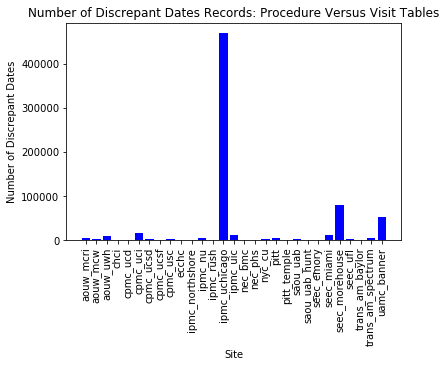

In [7]:
create_graphs(info_dict=procedure_bad_records, xlabel='Site', ylabel='Number of Discrepant Dates',
    title='Number of Discrepant Dates Records: Procedure Versus Visit Tables',
    img_name='procedure_visit_num_discrepant_records.jpg', color = 'b', total_diff_color = False)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


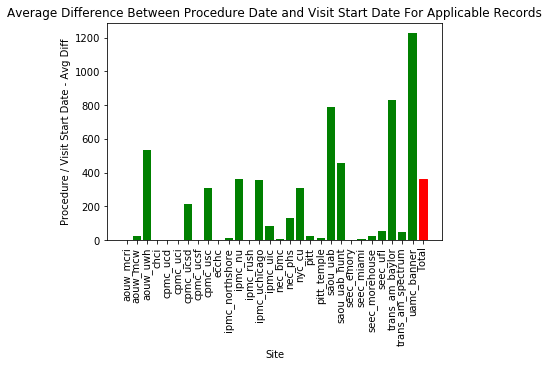

In [8]:
procedure_bad_records, procedure_vis_start_diff = \
create_dicts_w_info(procedure_visit_df, 'num_bad_records', 'procedure_vis_start_diff')

create_graphs(info_dict=procedure_vis_start_diff, xlabel='Site', ylabel='Procedure / Visit Start Date - Avg Diff',
    title='Average Difference Between Procedure Date and Visit Start Date For Applicable Records',
    img_name='procedure_visit_start_discrepancy.jpg', color = 'g', total_diff_color = True)

In [9]:
observation_visit_query = """
SELECT
DISTINCT
a.*, 
(a.observation_vis_start_diff + a.observation_vis_end_diff + a.observation_vis_start_dt_diff + a.observation_vis_end_dt_diff + a.observation_dt_vis_start_dt_diff + a.observation_dt_vis_end_dt_diff) as total_diff
FROM 
( SELECT
  mo.src_hpo_id, COUNT(mo.src_hpo_id) as num_bad_records, 
  IFNULL(ABS(DATE_DIFF(o.observation_date, vo.visit_start_date, DAY)), 0) as observation_vis_start_diff,
  IFNULL(ABS(DATE_DIFF(o.observation_date, vo.visit_end_date, DAY)), 0) as observation_vis_end_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), o.observation_date, DAY)), 0) as observation_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), o.observation_date, DAY)), 0) as observation_vis_end_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(o.observation_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)), 0) as observation_dt_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(o.observation_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY)), 0) as observation_dt_vis_end_dt_diff,

  (
  ABS(DATE_DIFF(o.observation_date, vo.visit_start_date, DAY)) = 
  ABS(DATE_DIFF(o.observation_date, vo.visit_end_date, DAY)) 
  AND
  ABS(DATE_DIFF(o.observation_date, vo.visit_end_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), o.observation_date, DAY)) 
  AND
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), o.observation_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), o.observation_date, DAY))
  AND
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), o.observation_date, DAY)) = 
  ABS(DATE_DIFF(CAST(o.observation_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) 
  AND
  ABS(DATE_DIFF(CAST(o.observation_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) = 
  ABS(DATE_DIFF(CAST(o.observation_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY))
  ) as all_discrepancies_equal

  FROM
  `{}.unioned_ehr_observation` o
  LEFT JOIN
  `{}._mapping_observation` mo
  ON
  o.observation_id = mo.observation_id
  LEFT JOIN
  `{}.unioned_ehr_visit_occurrence` vo
  ON
  o.visit_occurrence_id = vo.visit_occurrence_id

  WHERE
    -- must have populated visit occurrence id
    (
    o.visit_occurrence_id IS NOT NULL
    AND
    o.visit_occurrence_id <> 0
    AND
    vo.visit_occurrence_id IS NOT NULL
    AND
    vo.visit_occurrence_id <> 0
    )

  AND
    (
    -- problem with procedure date
    (o.observation_date < vo.visit_start_date
    OR
    o.observation_date > vo.visit_end_date)

    OR 
    -- problem with datetime
    (o.observation_datetime < vo.visit_start_datetime
    OR
    o.observation_datetime > vo.visit_end_datetime )

    OR
    -- problem with the datetime (extracting date for comparison)
    (o.observation_date < CAST(vo.visit_start_datetime AS DATE)
    OR
    o.observation_date > CAST(vo.visit_end_datetime AS DATE))
    
    OR
    
    --problem with the datetime
    (CAST(o.observation_datetime AS DATE) < CAST(vo.visit_start_datetime AS DATE)
    OR
    CAST(o.observation_datetime AS DATE) > CAST(vo.visit_end_datetime AS DATE)
    )
    )

  GROUP BY mo.src_hpo_id, o.observation_date, vo.visit_start_date, vo.visit_end_date, vo.visit_start_datetime, vo.visit_end_datetime, o.observation_datetime
  ORDER BY all_discrepancies_equal ASC, num_bad_records DESC
) a
WHERE
-- cannot compare date/datetime date accurately because of problem with UTC dates not converting properly. give 'wiggle room ' of 1
(
a.observation_vis_start_dt_diff > 1
OR
a.observation_vis_end_dt_diff > 1
OR
a.observation_vis_start_diff > 0
OR
a.observation_vis_end_diff > 0
OR
a.observation_dt_vis_start_dt_diff > 0
OR
a.observation_dt_vis_end_dt_diff > 0
)
ORDER BY src_hpo_id ASC, num_bad_records DESC, total_diff DESC, all_discrepancies_equal ASC
""".format(DATASET, DATASET, DATASET)

observation_visit_df = bq.query(observation_visit_query)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


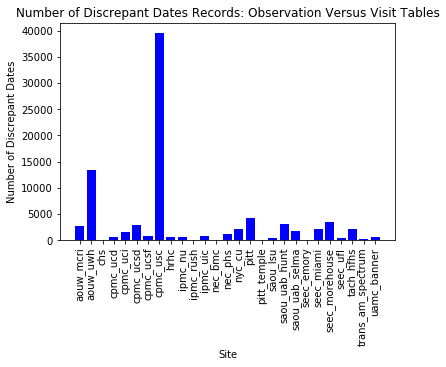

In [10]:
observation_bad_records, observation_vis_start_diff = \
create_dicts_w_info(observation_visit_df, 'num_bad_records', 'observation_vis_start_diff')

create_graphs(info_dict=observation_bad_records, xlabel='Site', ylabel='Number of Discrepant Dates',
    title='Number of Discrepant Dates Records: Observation Versus Visit Tables',
    img_name='observation_visit_num_discrepant_records.jpg', color = 'b', total_diff_color = False)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


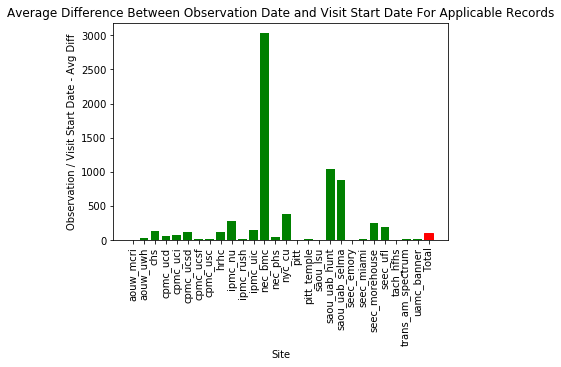

In [11]:
observation_bad_records, observation_vis_start_diff = \
create_dicts_w_info(observation_visit_df, 'num_bad_records', 'observation_vis_start_diff')

create_graphs(info_dict=observation_vis_start_diff, xlabel='Site', ylabel='Observation / Visit Start Date - Avg Diff',
    title='Average Difference Between Observation Date and Visit Start Date For Applicable Records',
    img_name='observation_visit_start_discrepancy.jpg', color = 'g', total_diff_color = True)

In [12]:
measurement_visit_query = """
SELECT
DISTINCT
a.*, 
(a.measurement_vis_start_diff + a.measurement_vis_end_diff + a.measurement_vis_start_dt_diff + a.measurement_vis_end_dt_diff + a.measurement_dt_vis_start_dt_diff + a.measurement_dt_vis_end_dt_diff) as total_diff
FROM 
( SELECT
  mm.src_hpo_id, COUNT(mm.src_hpo_id) as num_bad_records, 
  IFNULL(ABS(DATE_DIFF(m.measurement_date, vo.visit_start_date, DAY)), 0) as measurement_vis_start_diff,
  IFNULL(ABS(DATE_DIFF(m.measurement_date, vo.visit_end_date, DAY)), 0) as measurement_vis_end_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), m.measurement_date, DAY)), 0) as measurement_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), m.measurement_date, DAY)), 0) as measurement_vis_end_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(m.measurement_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)), 0) as measurement_dt_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(m.measurement_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY)), 0) as measurement_dt_vis_end_dt_diff,

  (
  ABS(DATE_DIFF(m.measurement_date, vo.visit_start_date, DAY)) = 
  ABS(DATE_DIFF(m.measurement_date, vo.visit_end_date, DAY)) 
  AND
  ABS(DATE_DIFF(m.measurement_date, vo.visit_end_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), m.measurement_date, DAY)) 
  AND
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), m.measurement_date, DAY)) =
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), m.measurement_date, DAY))
  AND
  ABS(DATE_DIFF(CAST(vo.visit_end_datetime AS DATE), m.measurement_date, DAY)) = 
  ABS(DATE_DIFF(CAST(m.measurement_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) 
  AND
  ABS(DATE_DIFF(CAST(m.measurement_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) = 
  ABS(DATE_DIFF(CAST(m.measurement_datetime AS DATE), CAST(vo.visit_end_datetime AS DATE), DAY))
  ) as all_discrepancies_equal

  FROM
  `{}.unioned_ehr_measurement` m
  LEFT JOIN
  `{}._mapping_measurement` mm
  ON
  m.measurement_id = mm.measurement_id
  LEFT JOIN
  `{}.unioned_ehr_visit_occurrence` vo
  ON
  m.visit_occurrence_id = vo.visit_occurrence_id

  WHERE
    -- must have populated visit occurrence id
    (
    m.visit_occurrence_id IS NOT NULL
    AND
    m.visit_occurrence_id <> 0
    AND
    vo.visit_occurrence_id IS NOT NULL
    AND
    vo.visit_occurrence_id <> 0
    )

  AND
    (
    -- problem with procedure date
    (m.measurement_date < vo.visit_start_date
    OR
    m.measurement_date > vo.visit_end_date)

    OR 
    -- problem with datetime
    (m.measurement_datetime < vo.visit_start_datetime
    OR
    m.measurement_datetime > vo.visit_end_datetime )

    OR
    -- problem with the datetime (extracting date for comparison)
    (m.measurement_date < CAST(vo.visit_start_datetime AS DATE)
    OR
    m.measurement_date > CAST(vo.visit_end_datetime AS DATE))
    
    OR
    
    --problem with the datetime
    (CAST(m.measurement_datetime AS DATE) < CAST(vo.visit_start_datetime AS DATE)
    OR
    CAST(m.measurement_datetime AS DATE) > CAST(vo.visit_end_datetime AS DATE)
    )
    )

  GROUP BY mm.src_hpo_id, m.measurement_date, vo.visit_start_date, vo.visit_end_date, vo.visit_start_datetime, vo.visit_end_datetime, m.measurement_datetime
  ORDER BY all_discrepancies_equal ASC, num_bad_records DESC
) a
WHERE
-- cannot compare date/datetime date accurately because of problem with UTC dates not converting properly. give 'wiggle room ' of 1
(
a.measurement_vis_start_dt_diff > 1
OR
a.measurement_vis_end_dt_diff > 1
OR
a.measurement_vis_start_diff > 0
OR
a.measurement_vis_end_diff > 0
OR
a.measurement_dt_vis_start_dt_diff > 0
OR
a.measurement_dt_vis_end_dt_diff > 0
)
ORDER BY src_hpo_id ASC, num_bad_records DESC, total_diff DESC, all_discrepancies_equal ASC
""".format(DATASET, DATASET, DATASET)

measurement_visit_df = bq.query(measurement_visit_query)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


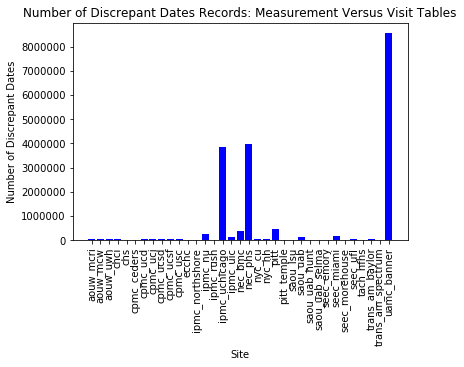

In [13]:
measurement_bad_records, measurement_vis_start_diff = \
create_dicts_w_info(measurement_visit_df, 'num_bad_records', 'measurement_vis_start_diff')

create_graphs(info_dict=measurement_bad_records, xlabel='Site', ylabel='Number of Discrepant Dates',
    title='Number of Discrepant Dates Records: Measurement Versus Visit Tables',
    img_name='measurement_visit_num_discrepant_records.jpg', color = 'b', total_diff_color = False)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


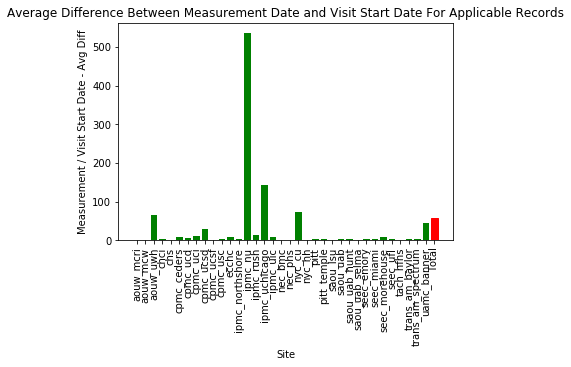

In [14]:
measurement_bad_records, measurement_vis_start_diff = \
create_dicts_w_info(measurement_visit_df, 'num_bad_records', 'measurement_vis_start_diff')

create_graphs(info_dict=measurement_vis_start_diff, xlabel='Site', ylabel='Measurement / Visit Start Date - Avg Diff',
    title='Average Difference Between Measurement Date and Visit Start Date For Applicable Records',
    img_name='measurement_visit_start_discrepancy.jpg', color = 'g', total_diff_color = True)

### NOTE: For the following cells, we are only using the 'start' dates for the visit table. This is because for the selected tables - condition_occurrence and drug_exposure - the relevant finding may extend past the visit.

In [15]:
condition_visit_query = """
SELECT
DISTINCT
a.*, 
(a.condition_vis_start_diff + a.condition_vis_start_dt_diff + a.condition_dt_vis_start_dt_diff) as total_diff
FROM 
( SELECT
  mco.src_hpo_id, COUNT(mco.src_hpo_id) as num_bad_records, 
  IFNULL(ABS(DATE_DIFF(co.condition_start_date, vo.visit_start_date, DAY)), 0) as condition_vis_start_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), co.condition_start_date, DAY)), 0) as condition_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(co.condition_start_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)), 0) as condition_dt_vis_start_dt_diff,
  
  (
  ABS(DATE_DIFF(co.condition_start_date, vo.visit_start_date, DAY)) = 
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), co.condition_start_date, DAY)) 
  AND
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), co.condition_start_date, DAY)) =
  ABS(DATE_DIFF(CAST(co.condition_start_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) 
  ) as all_discrepancies_equal

  FROM
  `{}.unioned_ehr_condition_occurrence` co
  LEFT JOIN
  `{}._mapping_condition_occurrence` mco
  ON
  co.condition_occurrence_id = mco.condition_occurrence_id
  LEFT JOIN
  `{}.unioned_ehr_visit_occurrence` vo
  ON
  co.visit_occurrence_id = vo.visit_occurrence_id

  WHERE
    -- must have populated visit occurrence id
    (
    co.visit_occurrence_id IS NOT NULL
    AND
    co.visit_occurrence_id <> 0
    AND
    vo.visit_occurrence_id IS NOT NULL
    AND
    vo.visit_occurrence_id <> 0
    )

  AND
    (
    -- problem with procedure date
    (co.condition_start_date < vo.visit_start_date)

    OR 
    -- problem with datetime
    (co.condition_start_datetime < vo.visit_start_datetime)

    OR
    -- problem with the datetime (extracting date for comparison)
    (co.condition_start_date < CAST(vo.visit_start_datetime AS DATE))
    
    OR
    
    --problem with the datetime
    (CAST(co.condition_start_datetime AS DATE) < CAST(vo.visit_start_datetime AS DATE))
    )

  GROUP BY mco.src_hpo_id, co.condition_start_date, vo.visit_start_date, vo.visit_end_date, vo.visit_start_datetime, vo.visit_end_datetime, co.condition_start_datetime
  ORDER BY all_discrepancies_equal ASC, num_bad_records DESC
) a
WHERE
-- cannot compare date/datetime date accurately because of problem with UTC dates not converting properly. give 'wiggle room ' of 1
(
a.condition_vis_start_dt_diff > 1
OR
a.condition_vis_start_diff > 0
OR
a.condition_dt_vis_start_dt_diff > 0
)
ORDER BY src_hpo_id ASC, num_bad_records DESC, total_diff DESC, all_discrepancies_equal ASC
""".format(DATASET, DATASET, DATASET)

condition_visit_df = bq.query(condition_visit_query)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


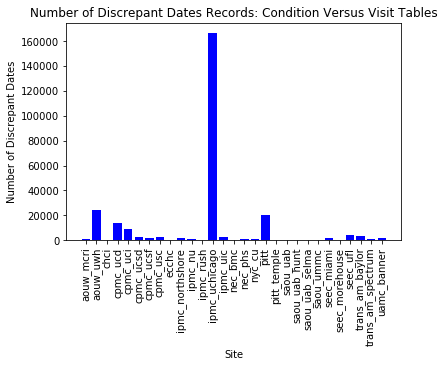

In [16]:
condition_bad_records, condition_vis_start_diff = \
create_dicts_w_info(condition_visit_df, 'num_bad_records', 'condition_vis_start_diff')

create_graphs(info_dict=condition_bad_records, xlabel='Site', ylabel='Number of Discrepant Dates',
    title='Number of Discrepant Dates Records: Condition Versus Visit Tables',
    img_name='condition_visit_num_discrepant_records.jpg', color = 'b', total_diff_color = False)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


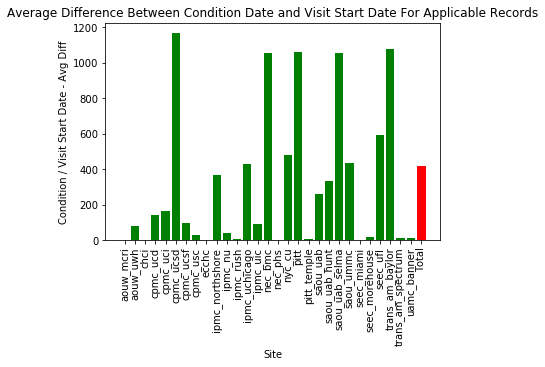

In [17]:
condition_bad_records, condition_vis_start_diff = \
create_dicts_w_info(condition_visit_df, 'num_bad_records', 'condition_vis_start_diff')

create_graphs(info_dict=condition_vis_start_diff, xlabel='Site', ylabel='Condition / Visit Start Date - Avg Diff',
    title='Average Difference Between Condition Date and Visit Start Date For Applicable Records',
    img_name='condition_visit_start_discrepancy.jpg', color = 'g', total_diff_color = True)

In [18]:
drug_visit_query = """
SELECT
DISTINCT
a.*, 
(a.drug_vis_start_diff + a.drug_vis_start_dt_diff + a.drug_dt_vis_start_dt_diff) as total_diff
FROM 
( SELECT
  mde.src_hpo_id, COUNT(mde.src_hpo_id) as num_bad_records, 
  IFNULL(ABS(DATE_DIFF(de.drug_exposure_start_date, vo.visit_start_date, DAY)), 0) as drug_vis_start_diff,
  IFNULL(ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), de.drug_exposure_start_date, DAY)), 0) as drug_vis_start_dt_diff,
  IFNULL(ABS(DATE_DIFF(CAST(de.drug_exposure_start_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)), 0) as drug_dt_vis_start_dt_diff,
  
  (
  ABS(DATE_DIFF(de.drug_exposure_start_date, vo.visit_start_date, DAY)) = 
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), de.drug_exposure_start_date, DAY)) 
  AND
  ABS(DATE_DIFF(CAST(vo.visit_start_datetime AS DATE), de.drug_exposure_start_date, DAY)) =
  ABS(DATE_DIFF(CAST(de.drug_exposure_start_datetime AS DATE), CAST(vo.visit_start_datetime AS DATE), DAY)) 
  ) as all_discrepancies_equal

  FROM
  `{}.unioned_ehr_drug_exposure` de
  LEFT JOIN
  `{}._mapping_drug_exposure` mde
  ON
  de.drug_exposure_id = mde.drug_exposure_id
  LEFT JOIN
  `{}.unioned_ehr_visit_occurrence` vo
  ON
  de.visit_occurrence_id = vo.visit_occurrence_id

  WHERE
    -- must have populated visit occurrence id
    (
    de.visit_occurrence_id IS NOT NULL
    AND
    de.visit_occurrence_id <> 0
    AND
    vo.visit_occurrence_id IS NOT NULL
    AND
    vo.visit_occurrence_id <> 0
    )

  AND
    (
    -- problem with procedure date
    (de.drug_exposure_start_date < vo.visit_start_date)

    OR 
    -- problem with datetime
    (de.drug_exposure_start_datetime < vo.visit_start_datetime)

    OR
    -- problem with the datetime (extracting date for comparison)
    (de.drug_exposure_start_date < CAST(vo.visit_start_datetime AS DATE))
    
    OR
    
    --problem with the datetime
    (CAST(de.drug_exposure_start_datetime AS DATE) < CAST(vo.visit_start_datetime AS DATE))
    )

  GROUP BY mde.src_hpo_id, de.drug_exposure_start_date, vo.visit_start_date, vo.visit_end_date, vo.visit_start_datetime, vo.visit_end_datetime, de.drug_exposure_start_datetime
  ORDER BY all_discrepancies_equal ASC, num_bad_records DESC
) a
WHERE
-- cannot compare date/datetime date accurately because of problem with UTC dates not converting properly. give 'wiggle room ' of 1
(
a.drug_vis_start_dt_diff > 1
OR
a.drug_vis_start_diff > 0
OR
a.drug_dt_vis_start_dt_diff > 0
)
ORDER BY src_hpo_id ASC, num_bad_records DESC, total_diff DESC, all_discrepancies_equal ASC
""".format(DATASET, DATASET, DATASET)

drug_visit_df = bq.query(drug_visit_query)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


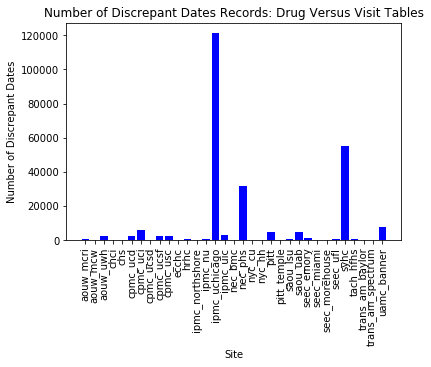

In [19]:
drug_bad_records, drug_vis_start_diff = \
create_dicts_w_info(drug_visit_df, 'num_bad_records', 'drug_vis_start_diff')

create_graphs(info_dict=drug_bad_records, xlabel='Site', ylabel='Number of Discrepant Dates',
    title='Number of Discrepant Dates Records: Drug Versus Visit Tables',
    img_name='drug_visit_num_discrepant_records.jpg', color = 'b', total_diff_color = False)

c:\users\ne2310\cdr_ops_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


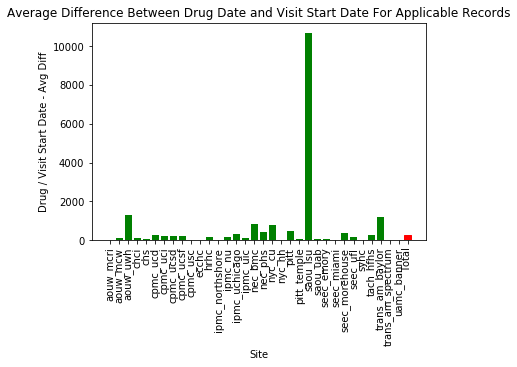

In [20]:
drug_bad_records, drug_vis_start_diff = \
create_dicts_w_info(drug_visit_df, 'num_bad_records', 'drug_vis_start_diff')

create_graphs(info_dict=drug_vis_start_diff, xlabel='Site', ylabel='Drug / Visit Start Date - Avg Diff',
    title='Average Difference Between Drug Date and Visit Start Date For Applicable Records',
    img_name='drug_visit_start_discrepancy.jpg', color = 'g', total_diff_color = True)